# Trending YouTube Categories insights
-------------------------------------------------------------------------------------
## Our purpose: 
### To provide Advertising Companies with more insights through the YouTube platform to help make better informed decisions when promoting products or services. Through our findings and conclusions we were able to come up with useful insights and perspectives to help reach those important desicions.

-------------------------------------------------------------------------------------

## Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import date
from IPython.core.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

# Helper Methods

In [59]:
def likeToDislikeRatio(likes, dislikes):
    likesRatio = (likes / (likes + dislikes)) * 100 
    return likesRatio

# likeToDislikeRatio(2334, 3246)


def filterByCategory(category):
    df_filtered = yt_df[yt_df['categories'].str.contains(category)]
    return df_filtered

# filterByCategory('comedy')


def showThumbnails(links):
    #Build HTML as string here
    style = '<style>.column,.row{padding:0 4px}.row{display:flex;flex-wrap:wrap}.column{flex:50%}.column img{margin-top:8px;vertical-align:middle}</style>'

    html = style + '<div class="column"> <div class="row">'

    for link in links:
        html += '<img src=' + link + ' width=100 height=80 style="float:left;width:90px;height:90px;margin:0"/>'
        # Style 1: html += '<img src=' + link + ' width=100 height=80 style="padding:1px;"/>'
        # Style 2: html += '<img src=' + link + ' width=100 height=80 style="float:left;width:80px;height:80px;margin:0"/>'

    html += '</div> </div>'

    # Display HTML
    return HTML(html)


# This method returns a wall of thumbnails (may include repetition [repetition = days trending])
def displayCategoryThumbnailWall(category):
    thumbnail_list = list(filterByCategory(category)['thumbnail_link'])
    return showThumbnails(thumbnail_list[:100])
    
    
# This method returns a wall of thumbnails (no repetitions)
def displayModifiedCategoryThumbnailWall(category):
    modified_thumbnail_list = []
    thumbnail_list = filterByCategory(category)['thumbnail_link']
    
    for thumbnail in thumbnail_list:
        if not thumbnail in modified_thumbnail_list:
            modified_thumbnail_list.append(thumbnail)
    return showThumbnails(modified_thumbnail_list[:100])


# Display Thumbnail Wall by taking in a list of thumbnails
def displayCustomListThumbnailWall(thumbnail_list):
    return showThumbnails(thumbnail_list[:100])
    

## - Read the YouTube DataSet and Categories from JSON file
## - Group id with value to create dictionary
## - Store zipped cat_ids with cat_titles under cat_dict

In [60]:
# Read the YouTube DataSet and Categories from JSON file
json_path = '/Users/matthew/Desktop/python_project/US_category_id.json'
yt_df = pd.read_csv('/Users/matthew/Desktop/python_project/USvideos.csv')
yt_json = pd.read_json(json_path, orient='columns')
cat_json = pd.read_json((yt_json['items']).to_json() , orient='index')
categories_table = pd.read_json((cat_json['snippet']).to_json() , orient='index')

# group id with value to create dictionary
cat_ids = cat_json['id'] 
cat_titles = categories_table['title']

# contains category id as the key and category as the value
cat_dict = dict(zip(cat_ids, cat_titles))


## Add columns to data frame (categories, number_of_tags, days_before_trending, over_1_mil_views, Like/Dislike Ratio, title_len)

In [103]:

# ------------------------------------ Adding categories ------------------------------------
# storing id column from yt_db
cat_id_list_from_main_db = yt_df['category_id']

# Checks every category id in a row and adds a category as a string
categories_col = [v.lower() for catId in cat_id_list_from_main_db for k, v in cat_dict.items() if catId == k]

# add new column to yt_db 
yt_df['categories'] = categories_col


# ------------------------------------ Adding number_of_tags ------------------------------------

tags_list = list(yt_df['tags'])
tags_list

number_of_tags_col = [len(tag.split('|')) for tag in tags_list]

yt_df['number_of_tags'] = number_of_tags_col


# ------------------------------------ Adding days_before_trending ------------------------------------


# TREND DATES
trend_date = yt_df['trending_date']
publish_date = yt_df['publish_time']
trend_dates = []
publish_dates = []
days_before_trending = []


for i in trend_date:

    trend_date = i.split('.')

    # YEAR
    trend_year = str(20) + trend_date[0]

    # MONTH
    trend_month = trend_date[2]
    if (trend_month[0] == str(0)):
        trend_month = trend_month[1]
    else:
        trend_month = trend_date[2]
        
    # DAY
    trend_day = trend_date[1]
    if (trend_day[0] == str(0)):
        trend_day = trend_day[1]
    else:
        trend_day = trend_date[1]
        
    trend_dates.append(trend_year + "/" + trend_month + "/" + trend_day)
    
    

# PUBLISH DATES

for j in publish_date:
    publish_date = j.split('-')
    
    # YEAR
    publish_year = publish_date[0]
    
    # MONTH
    publish_month = publish_date[1]
    if(publish_month[0] == str(0)):
        publish_month = publish_month[1]
    else:
        publish_month = publish_date[1] 
    
    # DAY
    publish_day = publish_date[2][:2]    

    if(publish_day[0] == str(0)):
        publish_day = publish_day[1]
    else:
        publish_day = publish_date[2][:2]
    
        
    publish_dates.append(publish_year + "/" + publish_month + "/" + publish_day)


videos = zip(publish_dates, trend_dates)
    
# CALCULATE DAYS
for p_date, t_date in videos:
    p_date = p_date.split('/')
    t_date = t_date.split('/')
    
    # PARSE
    p_year = int(p_date[0])
    t_year = int(t_date[0])

    p_month = int(p_date[1])
    t_month = int(t_date[1])
    
    p_day = int(p_date[2])
    t_day = int(t_date[2])
        
    
    upload = date(p_year, p_month, p_day)
    trend = date(t_year, t_month, t_day)
    delta = trend - upload
    days_before_trending.append(delta.days)

yt_df['days_before_trending'] = days_before_trending



# ------------------------------------ Adding over_1_mil_views ------------------------------------

# Add column to check if video has over 1 mil views. (true/false)
views_list = list(yt_df['views'])
over_1_mil_views_col = [True if views > 1000000 else False for views in views_list]
yt_df['over_1_mil_views'] = over_1_mil_views_col





# ------------------------------------ Adding Like/Dislike Ratio ------------------------------------

ratio_list = pd.DataFrame()

ratio_list = likeToDislikeRatio(yt_df['likes'], yt_df['dislikes'])
yt_df['like_ratio'] = ratio_list 


# ------------------------------------ Adding title length ------------------------------------

title_list = list(yt_df['title'])

title_len_col = [len(title.split(' ')) for title in title_list]
yt_df['title_len'] = title_len_col


# ------------------------------------ Display new table ------------------------------------

yt_df


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,description,categories,number_of_tags,days_before_trending,over_1_mil_views,like_ratio,title_len,trending_one_day,trending_three_day,trending_seven_day
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,people & blogs,1,1,False,95.096953,7,True,True,True
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,"One year after the presidential election, John...",entertainment,4,1,True,94.052124,10,True,True,True
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,comedy,23,2,True,96.472928,10,False,True,True
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,Today we find out if Link is a Nickelback amat...,entertainment,27,1,False,93.854955,5,True,True,True
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,I know it's been a while since we did this sho...,entertainment,14,2,True,98.518149,5,False,True,True
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,...,Using the iPhone for the past two weeks -- her...,science & technology,7,1,False,95.026280,5,True,True,True
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,...,Embattled Alabama Senate candidate Roy Moore (...,entertainment,42,2,True,86.739343,9,False,True,True
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,...,Ice Cream Pint Combination Lock - http://amzn....,science & technology,13,2,False,96.816824,8,False,True,True
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,...,"Inspired by the imagination of P.T. Barnum, Th...",film & animation,28,1,False,96.750410,12,True,True,True
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,...,"For now, at least, we have better things to wo...",news & politics,20,1,False,90.276093,12,True,True,True


----------------------------------------------------------------------------------------------------------
## What better way to represent data through not just numbers, but why not thumbnails. 
# Why? 
## Thumbnails can provide useful information about why a certain video may of been clicked and see things through a more human perspective. I managed to do this by showing the top 100 trending video thumbnails all at once and do the same for any specific category. 

# Here are the results for displaying the top 100 trending gaming thumbnails

In [7]:
displayModifiedCategoryThumbnailWall('gaming')

## You can see all the different thumbnails for gaming and see how a lot of the videos have a nintendo logo on it and see a noticable amount of nintendo related videos. You also see how the majority of the thumbnails show either a person or a group of people expressing their reactions as a way to bring attention and traffic to their videos. Much of this has to do with the practice of clickbaiting and for gaming, reactions play an important role in getting a user to click on their video and reach the trending page.

# Categories

In [98]:
# Neatly Display all categories to choose from
cat_set = {""}
for cat in yt_df['categories']:
    cat_set.add(cat)
cat_list = list(cat_set)[1:]
df = pd.DataFrame(cat_list)
df

,0
0,film & animation
1,entertainment
2,comedy
3,news & politics
4,sports
5,science & technology
6,pets & animals
7,travel & events
8,gaming
9,nonprofits & activism


## Here we can specify using one of our helper methods we created earlier to display trending videos under gaming

## We then use this result to display a new wall of thumbnails to show thumbnails in that category

In [99]:
filterByCategory('gaming')

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,description,categories,number_of_tags,days_before_trending,over_1_mil_views,like_ratio,title_len,trending_one_day,trending_three_day,trending_seven_day
131,lsfzA7sWlOM,17.14.11,L.A. Noire - Nintendo Switch Trailer,Nintendo,20,2017-11-09T19:59:48.000Z,"nintendo|""play""|""play nintendo""|""game""|""gamepl...",154872,7683,164,...,Amid the post-war boom of Hollywood's Golden A...,gaming,32,5,False,97.910029,6,False,False,True
392,lsfzA7sWlOM,17.15.11,L.A. Noire - Nintendo Switch Trailer,Nintendo,20,2017-11-09T19:59:48.000Z,"nintendo|""play""|""play nintendo""|""game""|""gamepl...",161231,7803,169,...,Amid the post-war boom of Hollywood's Golden A...,gaming,32,6,False,97.880080,6,False,False,True
405,EEIP1YpFXrE,17.16.11,Our First Date,iHasCupquake,20,2017-11-15T20:00:00.000Z,"first date|""animation""|""animated""|""short""|""sho...",224426,17784,225,...,Here's an animation short of our First Date! W...,gaming,26,1,False,98.750625,3,True,True,True
619,EEIP1YpFXrE,17.17.11,Our First Date,iHasCupquake,20,2017-11-15T20:00:00.000Z,"first date|""animation""|""animated""|""short""|""sho...",463992,25840,509,...,Here's an animation short of our First Date! W...,gaming,26,2,False,98.068238,3,False,True,True
652,hXcoq5XDwyA,17.17.11,Playing CUPHEAD with MatPat!,Butch Hartman,20,2017-11-15T22:02:34.000Z,"game theory|""film theory""|""cuphead""|""don't dea...",55460,3871,96,...,"After my appearance on GTLive, MatPat (Game Th...",gaming,15,2,False,97.580035,4,False,True,True
841,EEIP1YpFXrE,17.18.11,Our First Date,iHasCupquake,20,2017-11-15T20:00:00.000Z,"first date|""animation""|""animated""|""short""|""sho...",686170,32999,654,...,Here's an animation short of our First Date! W...,gaming,26,3,False,98.056637,3,False,True,True
875,hXcoq5XDwyA,17.18.11,Playing CUPHEAD with MatPat!,Butch Hartman,20,2017-11-15T22:02:34.000Z,"game theory|""film theory""|""cuphead""|""don't dea...",63841,4226,114,...,"After my appearance on GTLive, MatPat (Game Th...",gaming,15,3,False,97.373272,4,False,True,True
1066,EEIP1YpFXrE,17.19.11,Our First Date,iHasCupquake,20,2017-11-15T20:00:00.000Z,"first date|""animation""|""animated""|""short""|""sho...",925595,39452,766,...,Here's an animation short of our First Date! W...,gaming,26,4,False,98.095380,3,False,False,True
1098,hXcoq5XDwyA,17.19.11,Playing CUPHEAD with MatPat!,Butch Hartman,20,2017-11-15T22:02:34.000Z,"game theory|""film theory""|""cuphead""|""don't dea...",68145,4410,115,...,"After my appearance on GTLive, MatPat (Game Th...",gaming,15,4,False,97.458564,4,False,False,True
1292,EEIP1YpFXrE,17.20.11,Our First Date,iHasCupquake,20,2017-11-15T20:00:00.000Z,"first date|""animation""|""animated""|""short""|""sho...",1091211,43213,820,...,Here's an animation short of our First Date! W...,gaming,26,5,True,98.137760,3,False,False,True


In [10]:
displayCategoryThumbnailWall('gaming')

# Repetition = Number of days trending
## The reason why you see so many of the same thumbnails is because you are seeing the videos that are continuing to trend and each thumbnail you see represents another day of the same video being on the trending page. You will notice how there isnt much variation when it comes to gaming in this case and see how towards the bottom, nintendo had a good run for being on the trending page and starts fading away as you get to the top but can see a strong presence. You can also see the same patteren of the expression thumbnails. 

In [11]:
displayCategoryThumbnailWall('music')

## Under the music category, you see a heavy presence in music videos and more specifically from vevo and you also notice the use of a lot of darker colors being used in their thumbnails. This can open up creative ways in getting a brand noticed if they are able to get their product or service in the thumbnail and more importantly use brighter colors to help the ad placment get more noticed. 

------------------------------------------------------------------------------------------------------------
# Gilbert's

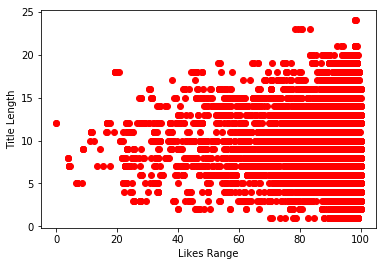

In [123]:

feature_cols = ['like_ratio']
X = yt_df[feature_cols]

# Assigned Labels after clustering: 
y = yt_df['title_len']

plt.scatter(X, y, color='r')
# plt.scatter(grades_range, boys_grades, color='g')
plt.xlabel('Likes Range')
plt.ylabel('Title Length')
plt.show()

## Although seemingly unrelated, we tried to discover any correlation between certain features that could possibly contain any data that could potentially be useful to advertisers. Using ratio between likes and dislikes, we wanted to see if the length of titles could offer some correlation of determining a higher or lower like ratio. Using a scatter plot, we observe that a sort of bell curve forms. In this curve, the range can be described in which shorter and longer titled videos had a higher like ratio. Videos with title lengths in between 5 to 15 words, on average, had lower dislike ratios. Although this may not prove much else, it was simply an attempt to see if some sort of correlation could be observed. 

accuracy score: 0.8157399009279286
ROC curve area: 0.8657467325409832


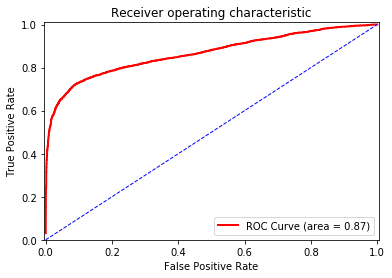

In [96]:
# Prediction on if a video gets over a million views based on these features
feature_cols = ['likes', 'dislikes', 'comment_count', 'number_of_tags', 'days_before_trending']

X = yt_df[feature_cols]
y = yt_df['over_1_mil_views']



# ---------- b ---------- 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=3)

# ---------- c ---------- 
my_logreg = LogisticRegression()
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print("accuracy score: {}".format(my_logreg_score))


y_predict_prob_lr = my_logreg.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

# AUC:
AUC = metrics.auc(fpr, tpr)
print("ROC curve area: {}".format(AUC))


%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

# After using the features from the feature_cols list, we can see that when comparing the simple accuracy score to the ROC curve area, the ROC Curve gives us a slightly better result

accuracy score: 0.7524271844660194
ROC curve area: 0.9698530358637565


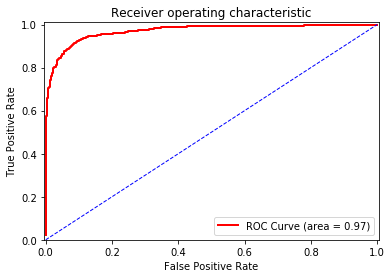

In [95]:
# Prediction by category.

cat_df = filterByCategory('music')
feature_cols = ['likes', 'dislikes', 'comment_count', 'number_of_tags', 'days_before_trending']

X = cat_df[feature_cols]
y = cat_df['over_1_mil_views']
# ---------- b ---------- 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=3)

# ---------- c ---------- 
my_logreg = LogisticRegression()
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print("accuracy score: {}".format(my_logreg_score))


y_predict_prob_lr = my_logreg.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

# AUC:
AUC = metrics.auc(fpr, tpr)
print("ROC curve area: {}".format(AUC))



plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

## For the music category, we can see that comparing the results from a simple accuracy score to the ROC Curve area, we get a better result

# For these examples we can see how narrowing down to a category leads to a more accurate result when compared to calculating the accuracy of the dataset as a whole
--------------------------------------------------------------------------------------------------------

# Gerardo's
# Gaming

In [68]:
cat_df = filterByCategory('gaming')

feature_cols = ['likes', 'number_of_tags', 'days_before_trending']

X = cat_df[feature_cols]
y = cat_df['over_1_mil_views']
# ---------- b ---------- 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=3)

# ---------- c ---------- 
my_logreg = LogisticRegression()
my_logreg.fit(X, y)
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print(my_logreg_score)

0.8216783216783217


In [69]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k) 
knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.9265734265734266


0.9201029601029601


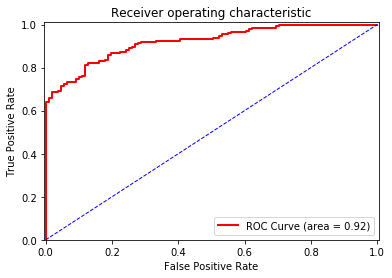

In [70]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_predict_prob_lr = my_logreg.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

# AUC:
AUC = metrics.auc(fpr, tpr)
print(AUC)


%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

### starting first with gaming. Through gaming I just wanted to emphasize more through matthews thumbnails when i tested to see what features to choose i chose(Likes, Number_of_tags and days_before_trending) which i tested trhough logistic and Kneighm=bor classifier came up to a percentage of 92% Ran through ROC which shows True postiive, False Positive useful since the algorithm stores all of the data. Through these percentages we can start to make our conclusion on why these features are the "best features". So through gaming the number of tags comes greatly into play because a game can have many different tags involved, type of game, family friendly, online, local only and the list goes on. So through these results we can conlude that a gaming video that has a good amount of tags will end with many likes and the video passing 1 million views.

# Comedy

In [71]:
cat_df = filterByCategory('comedy')

feature_cols = ['dislikes','comment_count']


X = cat_df[feature_cols]
y = cat_df['over_1_mil_views']
# ---------- b ---------- 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=3)

# ---------- c ---------- 
my_logreg = LogisticRegression()
my_logreg.fit(X, y)
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print(my_logreg_score)




0.8528925619834711


In [72]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k) 
knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.8991735537190083


0.9227693602693603


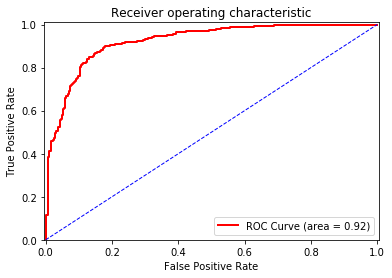

In [73]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_predict_prob_lr = my_logreg.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

# AUC:
AUC = metrics.auc(fpr, tpr)
print(AUC)


%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

### Comedy, not quite a similar category to gaming. Comedy can include a ton of very controversial topics so as a data scientist you also have to approach a topic or a specific dataset  as if you're against it in order to revieve the the accuracy you want using the same approach as the last category. I got the result of 92% accuracy using the best features i found. Which were dislikes and comment_count. Relying on the obvious isn't always proving a point but through this output. We can conclude that many people want to comment their insight on videos that invlolve comedy. Cause as said before comedy is a very controversial topic. So videos that usually recieve a lot of dislikes tend to recieve a lot of comments. These videos reach over a million quickly. Now while of course the ads put on these videos aren't explicitly supporting the jokes or topics covered in the video. An ad can still easily be slipped in these videos since it gets much attention. Using this to a business standpoint its a smart move to include ads in videos that casue such commotion since it has such an interactive audience which equals high attention.

In [124]:
cat_df = filterByCategory('comedy')

feature_cols = ['likes','comment_count']


X = cat_df[feature_cols]
y = cat_df['over_1_mil_views']
# ---------- b ---------- 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=3)

# ---------- c ---------- 
my_logreg = LogisticRegression()
my_logreg.fit(X, y)
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print(my_logreg_score)

0.4909090909090909


In [75]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k) 
knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.8504132231404958


0.9313809086536359


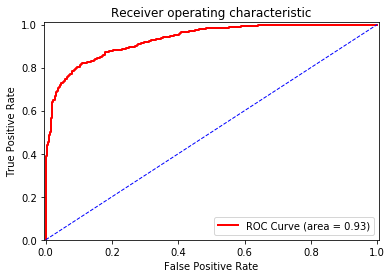

In [76]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_predict_prob_lr = my_logreg.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

# AUC:
AUC = metrics.auc(fpr, tpr)
print(AUC)


%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

# Pets

In [78]:
cat_df = filterByCategory('pets')

feature_cols = ['likes','comment_count']

X = cat_df[feature_cols]
y = cat_df['over_1_mil_views']
# ---------- b ---------- 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=3)

# ---------- c ---------- 
my_logreg = LogisticRegression()
my_logreg.fit(X, y)
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print(my_logreg_score)

0.8726708074534162


In [79]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k) 
knn.fit(X_train, y_train)

y_predict = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_predict)
print(accuracy)

0.9254658385093167


0.9214270432178006


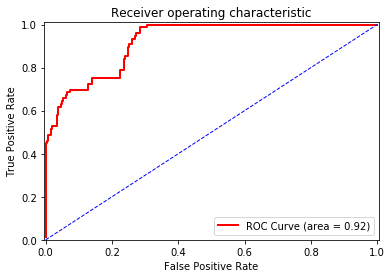

In [80]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_predict_prob_lr = my_logreg.predict_proba(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_prob_lr[:,1], pos_label=1)

# AUC:
AUC = metrics.auc(fpr, tpr)
print(AUC)


%matplotlib inline

plt.figure()

# Roc Curve:
plt.plot(fpr, tpr, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUC)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

### Understanding every category was a bit simple since im a very active user on youtube. Pets has always been an easy category to come across as easy to like. So i started with likes and comment count. Since pets always has a very active community since many pet owners have their own information or their own tips and tricks to help fellow pet owners. Here is a great category to focus selling ads on. Likes and comments are the best features. This category is 92% bound to have lots of likes and also a huge amount of comments. This audience clearly has great or good things to say about other pets. Or animals. Its a great category to put ads on and is easy to be proven.

# Garin
------------------------------------------------------------------------------------------------------------
# One of the things we wanted to achieve was to predict how long it would take for a video to reach the trending page.  First thing we had to do was remove all the duplicate videos in the csv file to eliminate as much error as possible.  Having duplicate videos would skew our result because each video should only be counted once.  Since all of the YouTube videos have their own video identification code, the best way to filter duplicate videos would be by using this identification code.  Using the drop duplicate function on the video identification code, we were able to reduce the amount of total videos from 40949 videos to 6351 videos!

In [125]:
df_clean = yt_df.drop_duplicates(['video_id'], keep='first')

days_before_trending_list = list(yt_df['days_before_trending'])
trending_one_day_col = [True if days_before_trending <= 1 else False for days_before_trending in days_before_trending_list]
yt_df['trending_one_day'] = trending_one_day_col

days_before_trending_list = list(yt_df['days_before_trending'])
trending_three_day_col = [True if days_before_trending <= 3 else False for days_before_trending in days_before_trending_list]
yt_df['trending_three_day'] = trending_three_day_col

days_before_trending_list = list(yt_df['days_before_trending'])
trending_seven_day_col = [True if days_before_trending <= 7 else False for days_before_trending in days_before_trending_list]
yt_df['trending_seven_day'] = trending_seven_day_col


feature_cols = ['likes', 'dislikes', 'comment_count', 'number_of_tags', 'days_before_trending']

X = df_clean[feature_cols]
y_1 = df_clean['trending_one_day']
y_3 = df_clean['trending_three_day']
y_7 = df_clean['trending_seven_day']

X_train, X_test, y_train, y_test = train_test_split(X, y_1, test_size=0.35, random_state=3)
my_logreg = LogisticRegression()
my_logreg.fit(X, y_1)
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print(my_logreg_score)

X_train, X_test, y_train, y_test = train_test_split(X, y_3, test_size=0.35, random_state=3)
my_logreg = LogisticRegression()
my_logreg.fit(X, y_3)
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print(my_logreg_score)

X_train, X_test, y_train, y_test = train_test_split(X, y_7, test_size=0.35, random_state=3)
my_logreg = LogisticRegression()
my_logreg.fit(X, y_7)
my_logreg.fit(X_train, y_train)
my_logreg_y_predict = my_logreg.predict(X_test)
my_logreg_score = accuracy_score(y_test, my_logreg_y_predict)
print(my_logreg_score)
df_clean

1.0
0.8717948717948718
0.9914529914529915


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,description,categories,number_of_tags,days_before_trending,over_1_mil_views,like_ratio,title_len,trending_one_day,trending_three_day,trending_seven_day
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,SHANTELL'S CHANNEL - https://www.youtube.com/s...,people & blogs,1,1,False,95.096953,7,True,True,True
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,"One year after the presidential election, John...",entertainment,4,1,True,94.052124,10,True,True,True
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,comedy,23,2,True,96.472928,10,False,True,True
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,Today we find out if Link is a Nickelback amat...,entertainment,27,1,False,93.854955,5,True,True,True
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,I know it's been a while since we did this sho...,entertainment,14,2,True,98.518149,5,False,True,True
5,gHZ1Qz0KiKM,17.14.11,2 Weeks with iPhone X,iJustine,28,2017-11-13T19:07:23.000Z,"ijustine|""week with iPhone X""|""iphone x""|""appl...",119180,9763,511,...,Using the iPhone for the past two weeks -- her...,science & technology,7,1,False,95.026280,5,True,True,True
6,39idVpFF7NQ,17.14.11,Roy Moore & Jeff Sessions Cold Open - SNL,Saturday Night Live,24,2017-11-12T05:37:17.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",2103417,15993,2445,...,Embattled Alabama Senate candidate Roy Moore (...,entertainment,42,2,True,86.739343,9,False,True,True
7,nc99ccSXST0,17.14.11,5 Ice Cream Gadgets put to the Test,CrazyRussianHacker,28,2017-11-12T21:50:37.000Z,"5 Ice Cream Gadgets|""Ice Cream""|""Cream Sandwic...",817732,23663,778,...,Ice Cream Pint Combination Lock - http://amzn....,science & technology,13,2,False,96.816824,8,False,True,True
8,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059,3543,119,...,"Inspired by the imagination of P.T. Barnum, Th...",film & animation,28,1,False,96.750410,12,True,True,True
9,TUmyygCMMGA,17.14.11,Why the rise of the robots won’t mean the end ...,Vox,25,2017-11-13T13:45:16.000Z,"vox.com|""vox""|""explain""|""shift change""|""future...",256426,12654,1363,...,"For now, at least, we have better things to wo...",news & politics,20,1,False,90.276093,12,True,True,True


In [100]:
displayCustomListThumbnailWall(df_clean['thumbnail_link'])

# Here is a representation of a clean (no duplicate) top 100 trending video thumbnails